In [ ]:
# Install necessary libraries
!pip install scipy
!pip install stable-baselines3[extra]
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 890.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 16.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from stable_baselines3 import PPO
from gymnasium import spaces
import gymnasium as gym
from stable_baselines3.common.env_checker import check_env
import pandas as pd

# Solution with static SOC modelling

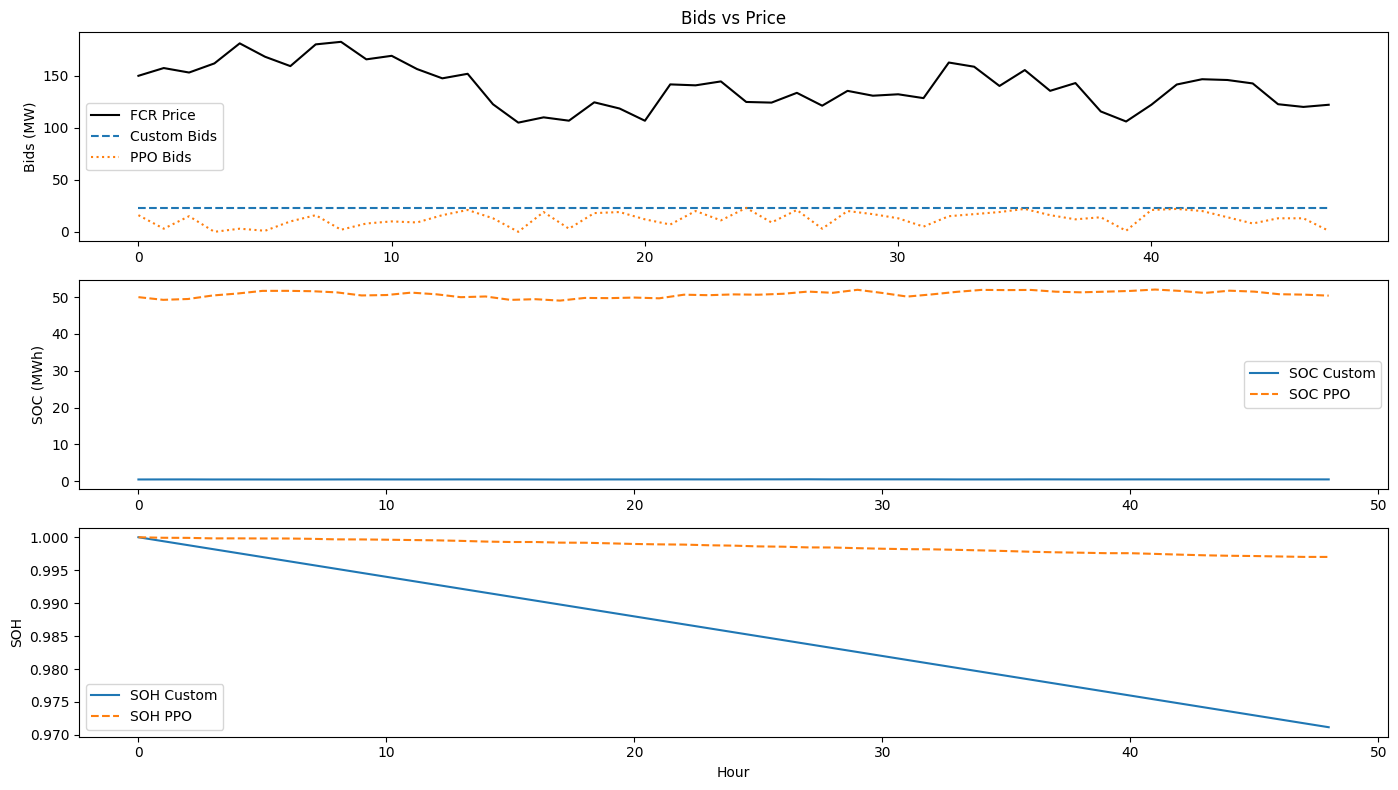


=== Comparative Performance Dashboard ===

               Metric  Custom Algorithm  PPO Agent
    Total Revenue (€)       154546.7500  81355.870
            Final SOH            0.9712      0.997
Constraint Violations            0.0000      0.000
    Stability of Bids            0.0000      9.837
Adaptability to Price            0.0000      0.088


In [ ]:
# === COMMON SETTINGS ===
E_max = 100.0
P_max = 23.0
eta_rt = 0.9
soc0 = 0.5
soh0 = 1.0
k1, k2, beta = 1e-5, 1e-5, 1.3
DoD = 0.2
n_hours = 48
hysteresis_margin = 0.05
gamma = 0.3  # Degradation penalty weight

np.random.seed(42)

def generate_fcr_prices(mu=150, theta=0.3, sigma=15, p0=150, n=24):
    prices = [p0]
    for _ in range(n - 1):
        dP = theta * (mu - prices[-1]) + sigma * np.random.normal()
        prices.append(max(0, prices[-1] + dP))
    return prices

fcr_prices = generate_fcr_prices(n=n_hours)

# === CUSTOM STRATEGY ===
def get_available_power(soc, soh):
    margin = hysteresis_margin
    power_avail = 2 * soh * E_max * min(soc, 1 - soc)
    return max(0.0, min(P_max, power_avail - margin))

def update_soh(soh, energy_cycled):
    delta_soh = k1 * (energy_cycled)**beta + k2 * (energy_cycled / (DoD * E_max))
    return max(0.0, soh - delta_soh)

custom_soc, custom_soh = soc0, soh0
soc_history_c, soh_history_c, bids_c, violations_c = [], [], [], 0
revenue_c = 0

for t in range(n_hours):
    soc_history_c.append(custom_soc)
    soh_history_c.append(custom_soh)

    P_avail = get_available_power(custom_soc, custom_soh)
    result = linprog(c=[-fcr_prices[t]], A_ub=[[1]], b_ub=[P_avail], bounds=[(0, P_max)], method='highs')
    bid = result.x[0] if result.success else 0.0
    bids_c.append(bid)
    revenue_c += bid * fcr_prices[t]

    if bid > P_avail:
        violations_c += 1

    custom_soc = np.clip(custom_soc + np.random.normal(0, 0.01), 0.1, 0.9)
    energy_cycled = bid
    custom_soh = update_soh(custom_soh, energy_cycled)

soc_history_c.append(custom_soc)
soh_history_c.append(custom_soh)

bid_changes_c = np.diff(bids_c)
stability_c = np.std(bid_changes_c)

# === Simplified Adaptability Calculation ===
def compute_adaptability(actions, prices):
    # Calculate percentage change, avoiding divide by zero
    price_changes = np.diff(prices) / prices[:-1]  # Relative change in price
    action_changes = np.diff(actions) / np.maximum(actions[:-1], 1e-5)  # Avoid division by zero by replacing with small value

    # Filter out zero or constant values in actions or prices to avoid invalid correlation
    valid_indices = np.isfinite(price_changes) & np.isfinite(action_changes) & (price_changes != 0) & (action_changes != 0)

    if np.sum(valid_indices) > 1:  # At least 2 valid points required for correlation
        adaptability = np.corrcoef(price_changes[valid_indices], action_changes[valid_indices])[0, 1]
    else:
        adaptability = 0.0  # Return 0 if not enough data to compute adaptability

    return adaptability

adaptability_c = compute_adaptability(bids_c, fcr_prices)

# === PPO ENVIRONMENT WITH REWARD SHAPING ===
class HybridFCREnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.max_power = 23
        self.e_max = E_max
        self.low_soc, self.high_soc = 0.3 * self.e_max, 0.7 * self.e_max
        self.k1, self.k2, self.beta = 1e-5, 1e-5, 1.3
        self.DoD = DoD
        self.dt = 1
        self.gamma = gamma
        self.n_hours = n_hours
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0, 0], dtype=np.float32),
            high=np.array([23, self.e_max, 1.0, 300], dtype=np.float32),
            dtype=np.float32
        )
        self.action_space = spaces.Discrete(self.max_power + 1)
        self.reset()

    def reset(self, seed=None):
        self.hour = 0
        self.soc = 0.5 * self.e_max
        self.soh = 1.0
        self.prices = fcr_prices
        self.rewards, self.socs, self.sohs, self.bids = [], [self.soc], [self.soh], []
        return self._get_obs(), {}

    def _get_obs(self):
        # Ensure the hour is within the range of prices
        self.hour = self.hour % len(self.prices)
        return np.array([self.hour, self.soc, self.soh, self.prices[self.hour]], dtype=np.float32)

    def step(self, action):
        if self.soc < self.low_soc or self.soc > self.high_soc:
            action = 0

        bid_power = action
        price = self.prices[self.hour]
        energy_reserved = bid_power * self.dt
        e_cycled = energy_reserved * 0.5
        dod = energy_reserved / self.e_max
        soh_loss = self.k1 * e_cycled + self.k2 * (dod ** self.beta)
        self.soh = max(0.0, self.soh - soh_loss)

        self.soc += np.random.uniform(-1, 1)
        self.soc = np.clip(self.soc, 0, self.e_max)

        reward = bid_power * price - self.gamma * soh_loss * 1e6
        self.rewards.append(reward)
        self.socs.append(self.soc)
        self.sohs.append(self.soh)
        self.bids.append(bid_power)

        self.hour += 1
        done = self.hour == self.n_hours
        return self._get_obs(), float(reward), done, False, {}

# === TRAIN PPO ===
env = HybridFCREnv()
check_env(env)

model = PPO("MlpPolicy", env, verbose=0)
model.learn(total_timesteps=50000)  # Increased timesteps

# === RUN PPO ===
obs, _ = env.reset()
rewards_rl, actions_rl = [], []
for _ in range(env.n_hours):
    action, _ = model.predict(obs)
    obs, reward, done, _, _ = env.step(action)
    rewards_rl.append(reward)
    actions_rl.append(action)
    if done:
        break

# === Handling invalid values in adaptability calculation ===
actions_rl = np.array(actions_rl)
fcr_prices = np.array(fcr_prices)

# Compute adaptability for PPO model
adaptability_rl = compute_adaptability(actions_rl, fcr_prices)

# === PLOTS ===
plt.figure(figsize=(14, 8))

plt.subplot(3, 1, 1)
plt.plot(fcr_prices, label="FCR Price", color='black')
plt.plot(bids_c, label="Custom Bids", linestyle='--')
plt.plot(actions_rl, label="PPO Bids", linestyle=':')
plt.ylabel("Bids (MW)"); plt.title("Bids vs Price"); plt.legend()

plt.subplot(3, 1, 2)
plt.plot(soc_history_c, label="SOC Custom")
plt.plot(env.socs, label="SOC PPO", linestyle='--')
plt.ylabel("SOC (MWh)"); plt.legend()

plt.subplot(3, 1, 3)
plt.plot(soh_history_c, label="SOH Custom")
plt.plot(env.sohs, label="SOH PPO", linestyle='--')
plt.ylabel("SOH"); plt.xlabel("Hour"); plt.legend()

plt.tight_layout(); plt.show()

# === COMPARISON DASHBOARD ===
final_soh_c = soh_history_c[-1]  # Fix for missing variable

comparison = pd.DataFrame({
    "Metric": ["Total Revenue (€)", "Final SOH", "Constraint Violations", "Stability of Bids", "Adaptability to Price"],
    "Custom Algorithm": [round(revenue_c, 2), round(final_soh_c, 4), violations_c, round(stability_c, 3), round(adaptability_c, 3)],
    "PPO Agent": [round(np.sum(rewards_rl), 2), round(env.sohs[-1], 4), 0, round(np.std(np.diff(actions_rl)), 3), round(adaptability_rl, 3)],
})

print("\n=== Comparative Performance Dashboard ===\n")
print(comparison.to_string(index=False))


# Solution with dynamic SOC modelling

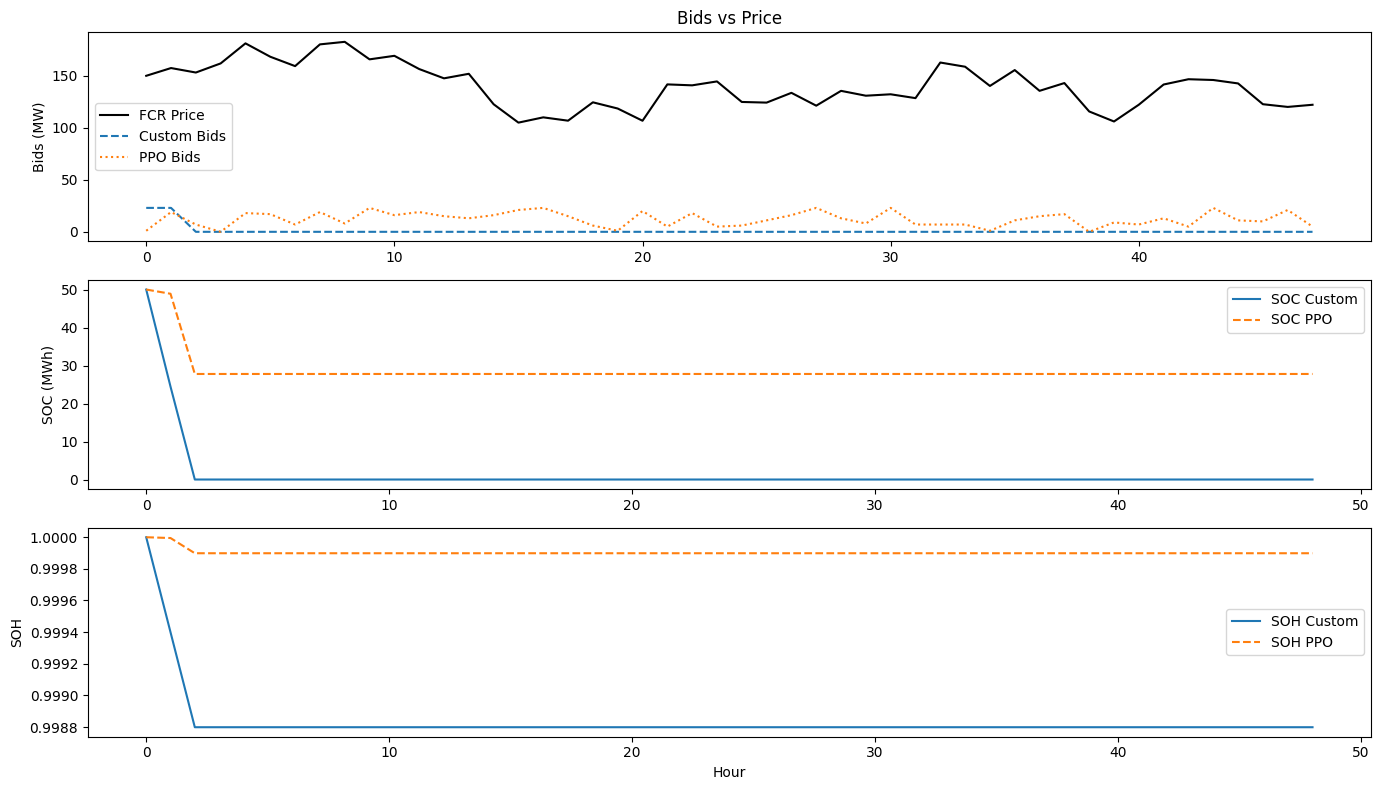


=== Comparative Performance Dashboard ===

               Metric  Custom Algorithm  PPO Agent
    Total Revenue (€)         7071.3700  3111.2100
            Final SOH            0.9988     0.9999
Constraint Violations            0.0000     0.0000
    Stability of Bids            3.3190    10.1310
Adaptability to Price            0.0000     0.1100


In [ ]:

# === IMPORTS ===
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from stable_baselines3 import PPO
from gymnasium import spaces
import gymnasium as gym
from stable_baselines3.common.env_checker import check_env
import pandas as pd

# === SETTINGS ===
E_max = 100.0  # Max energy (MWh)
P_max = 23.0   # Max power (MW)
eta_rt = 0.9   # Round-trip efficiency
soc0 = 0.5 * E_max
soh0 = 1.0
k1, k2, beta = 1e-5, 1e-5, 1.3
DoD = 0.2
n_hours = 48
hysteresis_margin = 0.05
gamma = 0.3  # Degradation penalty weight

np.random.seed(42)

# === PRICE GENERATION ===
def generate_fcr_prices(mu=150, theta=0.3, sigma=15, p0=150, n=48):
    prices = [p0]
    for _ in range(n - 1):
        dP = theta * (mu - prices[-1]) + sigma * np.random.normal()
        prices.append(max(0, prices[-1] + dP))
    return prices

fcr_prices = generate_fcr_prices(n=n_hours)

# === SOC/SoH MODELS ===
def get_available_power(soc, soh):
    margin = hysteresis_margin
    power_avail = 2 * soh * E_max * min(soc / E_max, 1 - soc / E_max)
    return max(0.0, min(P_max, power_avail - margin))

def update_soh(soh, energy_cycled):
    delta_soh = k1 * (energy_cycled)**beta + k2 * (energy_cycled / (DoD * E_max))
    return max(0.0, soh - delta_soh)

def update_soc_dynamic(soc, bid_power, dt=1):
    energy_used = bid_power * dt
    return np.clip(soc - energy_used / eta_rt, 0, E_max)

# === CUSTOM ALGORITHM ===
custom_soc, custom_soh = soc0, soh0
soc_history_c, soh_history_c, bids_c, violations_c = [], [], [], 0
revenue_c = 0

for t in range(n_hours):
    soc_history_c.append(custom_soc)
    soh_history_c.append(custom_soh)

    P_avail = get_available_power(custom_soc, custom_soh)
    result = linprog(c=[-fcr_prices[t]], A_ub=[[1]], b_ub=[P_avail], bounds=[(0, P_max)], method='highs')
    bid = result.x[0] if result.success else 0.0
    bids_c.append(bid)
    revenue_c += bid * fcr_prices[t]

    if bid > P_avail:
        violations_c += 1

    energy_cycled = bid
    custom_soc = update_soc_dynamic(custom_soc, bid)
    custom_soh = update_soh(custom_soh, energy_cycled)

soc_history_c.append(custom_soc)
soh_history_c.append(custom_soh)
bid_changes_c = np.diff(bids_c)
stability_c = np.std(bid_changes_c)

# === Adaptability ===
def compute_adaptability(actions, prices):
    price_changes = np.diff(prices) / prices[:-1]
    action_changes = np.diff(actions) / np.maximum(actions[:-1], 1e-5)
    valid = np.isfinite(price_changes) & np.isfinite(action_changes) & (price_changes != 0) & (action_changes != 0)
    return np.corrcoef(price_changes[valid], action_changes[valid])[0, 1] if np.sum(valid) > 1 else 0.0

adaptability_c = compute_adaptability(bids_c, fcr_prices)

# === PPO ENVIRONMENT ===
class FCREnvDynamic(gym.Env):
    def __init__(self):
        super().__init__()
        self.max_power = P_max
        self.e_max = E_max
        self.k1, self.k2, self.beta = k1, k2, beta
        self.DoD = DoD
        self.dt = 1
        self.gamma = gamma
        self.n_hours = n_hours
        self.low_soc, self.high_soc = 0.3 * self.e_max, 0.7 * self.e_max

        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0, 0], dtype=np.float32),
            high=np.array([23, self.e_max, 1.0, 300], dtype=np.float32),
            dtype=np.float32
        )
        self.action_space = spaces.Discrete(int(self.max_power) + 1)
        self.reset()

    def reset(self, seed=None):
        self.hour = 0
        self.soc = soc0
        self.soh = soh0
        self.prices = fcr_prices
        self.rewards, self.socs, self.sohs, self.bids = [], [self.soc], [self.soh], []
        return self._get_obs(), {}

    def _get_obs(self):
        # Ensure we don't go out of bounds
        price = self.prices[min(self.hour, self.n_hours - 1)]
        return np.array([self.hour, self.soc, self.soh, price], dtype=np.float32)

    def step(self, action):
        if self.soc < self.low_soc or self.soc > self.high_soc:
            action = 0

        bid_power = action
        energy_reserved = bid_power * self.dt
        e_cycled = energy_reserved * 0.5
        dod = energy_reserved / self.e_max
        soh_loss = self.k1 * e_cycled + self.k2 * (dod ** self.beta)
        self.soh = max(0.0, self.soh - soh_loss)

        self.soc = update_soc_dynamic(self.soc, bid_power)
        reward = bid_power * self.prices[self.hour] - self.gamma * soh_loss * 1e6

        self.rewards.append(reward)
        self.socs.append(self.soc)
        self.sohs.append(self.soh)
        self.bids.append(bid_power)

        self.hour += 1
        done = self.hour == self.n_hours

        # Fix: Avoid out-of-bounds error by guarding _get_obs
        if done:
            obs = np.zeros_like(self._get_obs())
        else:
            obs = self._get_obs()

        return obs, float(reward), done, False, {}

# === TRAIN PPO ===
env = FCREnvDynamic()
check_env(env)

model = PPO("MlpPolicy", env, verbose=0)
model.learn(total_timesteps=50000)

# === RUN PPO AGENT ===
obs, _ = env.reset()
rewards_rl, actions_rl = [], []

for _ in range(env.n_hours):
    action, _ = model.predict(obs)
    obs, reward, done, _, _ = env.step(action)
    rewards_rl.append(reward)
    actions_rl.append(action)
    if done:
        break

actions_rl = np.array(actions_rl)
adaptability_rl = compute_adaptability(actions_rl, fcr_prices)

# === PLOTS ===
plt.figure(figsize=(14, 8))

plt.subplot(3, 1, 1)
plt.plot(fcr_prices, label="FCR Price", color='black')
plt.plot(bids_c, label="Custom Bids", linestyle='--')
plt.plot(actions_rl, label="PPO Bids", linestyle=':')
plt.ylabel("Bids (MW)"); plt.title("Bids vs Price"); plt.legend()

plt.subplot(3, 1, 2)
plt.plot(soc_history_c, label="SOC Custom")
plt.plot(env.socs, label="SOC PPO", linestyle='--')
plt.ylabel("SOC (MWh)"); plt.legend()

plt.subplot(3, 1, 3)
plt.plot(soh_history_c, label="SOH Custom")
plt.plot(env.sohs, label="SOH PPO", linestyle='--')
plt.ylabel("SOH"); plt.xlabel("Hour"); plt.legend()

plt.tight_layout(); plt.show()

# === COMPARISON METRICS ===
comparison = pd.DataFrame({
    "Metric": ["Total Revenue (€)", "Final SOH", "Constraint Violations", "Stability of Bids", "Adaptability to Price"],
    "Custom Algorithm": [round(revenue_c, 2), round(soh_history_c[-1], 4), violations_c, round(stability_c, 3), round(adaptability_c, 3)],
    "PPO Agent": [round(np.sum(rewards_rl), 2), round(env.sohs[-1], 4), 0, round(np.std(np.diff(actions_rl)), 3), round(adaptability_rl, 3)],
})

print("\n=== Comparative Performance Dashboard ===\n")
print(comparison.to_string(index=False))

